In [28]:
# training a model with pre-defined (and saved) train / test datasets

In [1]:
# reading the data ml-latest-small
import pandas as pd
import zipfile
import numpy as np 
zf = zipfile.ZipFile('/home/elena/Downloads/ml-latest-small.zip')
# reading ratings file:
r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv(zf.open('ml-latest-small/ratings.csv'), names=r_cols)
m_cols=['movie_id', 'title', 'genre']
movies = pd.read_csv(zf.open('ml-latest-small/movies.csv'), names=m_cols)
# merging ratings and movies
data=pd.merge(ratings,movies,on='movie_id')
data.head()

,user_id,movie_id,rating,unix_timestamp,title,genre
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,847434962,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,1106635946,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,1510577970,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,1305696483,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


In [2]:
zz = zipfile.ZipFile('/home/elena/Downloads/ml-100k.zip')
# reading users file:
u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv(zz.open('ml-100k/u.user'), sep='|', names=u_cols,encoding='latin-1')
data=pd.merge(users,data, on='user_id')
data.head()

,user_id,age,sex,occupation,zip_code,movie_id,rating,unix_timestamp,title,genre
0,1,24,M,technician,85711,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,24,M,technician,85711,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance
2,1,24,M,technician,85711,6,4.0,964982224,Heat (1995),Action|Crime|Thriller
3,1,24,M,technician,85711,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,24,M,technician,85711,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


In [3]:
data.movie_id.unique().shape[0], data.user_id.unique().shape[0], data.shape

(9724, 610, (100836, 10))

In [4]:
# splitting into train and test data
# data was split and safed! 
train=pd.read_pickle('/home/elena/Downloads/traindata.pkl')
test=pd.read_pickle('/home/elena/Downloads/testdata.pkl')

In [5]:
train.head()

,user_id,age,sex,occupation,zip_code,movie_id,rating,unix_timestamp,title,genre
97717,606,28,M,programmer,63044,3462,4.0,1171501099,Modern Times (1936),Comedy|Drama|Romance
100124,610,22,M,student,21227,8914,4.0,1493845360,Primer (2004),Drama|Sci-Fi
25952,180,22,F,administrator,60202,1196,4.0,1270237862,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Sci-Fi
25871,178,26,M,other,49512,2231,4.5,1163673637,Rounders (1998),Drama
97255,605,33,M,engineer,33716,1588,4.0,1277094877,George of the Jungle (1997),Children|Comedy


In [6]:
data.movie_id.max(), data.user_id.max(), train.movie_id.max(), train.user_id.max()

(193609, 610, 193609, 610)

In [12]:
# Implementation 
from keras.layers import Input, Embedding, Concatenate, Flatten, Dense, Dot, Add, Multiply, Subtract, Average
from keras.models import Model
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [13]:
def embedding_model(hidden_units, user_embedding_dim, user_max_cat_value, movie_embedding_dim, movie_max_cat_value,merging_method):
    # Each instance will consist of two inputs: a single user id, and a single movie id
    user_id_input = Input(shape=(1,), name='user_id')
    movie_id_input = Input(shape=(1,), name='movie_id')
    # Embeddings
    user_embedded = Embedding(user_max_cat_value+1, user_embedding_dim, 
                                       input_length=1, name='user_embedding')(user_id_input)
    movie_embedded = Embedding(movie_max_cat_value+1, movie_embedding_dim, 
                                        input_length=1, name='movie_embedding')(movie_id_input)
    # merging the embeddings
    if merging_method=='concatenate':
        merged = Concatenate()([user_embedded, movie_embedded])
    if merging_method=='dot_product':
        merged =Dot(name = 'dot_product', normalize = True, axes = 2)([user_embedded, movie_embedded])
    if merging_method=='add':
        merged =Add()([user_embedded, movie_embedded])
    if merging_method=='substract':
        merged=Subtract()([user_embedded, movie_embedded])
    if merging_method=='multiply':
        merged=Multiply()([user_embedded, movie_embedded])
    if merging_method=='average':
        merged=Average()([user_embedded, movie_embedded])
    out = Flatten()(merged)

    # Add one or more hidden layers
    for n_hidden in hidden_units:
        out = Dense(n_hidden, activation='relu')(out)

    # A single output: our predicted rating
    out = Dense(1, activation='linear', name='prediction')(out)
    return Model(inputs = [user_id_input, movie_id_input],outputs = out)

In [14]:
hidden_units = (100,50) #same as in pytorch model
movie_embedding_dim = 50 #same as in pytorch model
user_embedding_dim = 50  #same as in pytorch model
user_max_cat_value = data.user_id.max()
movie_max_cat_value=data.movie_id.max()
model_concatenate=embedding_model(hidden_units, user_embedding_dim, user_max_cat_value, movie_embedding_dim, movie_max_cat_value, merging_method='concatenate')
model_concatenate.summary(line_length=88)

Model: "model_1"
________________________________________________________________________________________
Layer (type)                 Output Shape       Param #   Connected to                  
user_id (InputLayer)         (None, 1)          0                                       
________________________________________________________________________________________
movie_id (InputLayer)        (None, 1)          0                                       
________________________________________________________________________________________
user_embedding (Embedding)   (None, 1, 50)      30550     user_id[0][0]                 
________________________________________________________________________________________
movie_embedding (Embedding)  (None, 1, 50)      9680500   movie_id[0][0]                
________________________________________________________________________________________
concatenate_1 (Concatenate)  (None, 1, 100)     0         user_embedding[0][0]          
    

In [15]:
# compiling / new version
model_concatenate.compile(optimizer = 'Adam',loss='MSE',metrics=['MAE'])
# early stopping
es=EarlyStopping(monitor='val_MAE', min_delta=0, patience=0, verbose=0, mode='min', baseline=None, restore_best_weights=False)
# training and using the pre-defined train and test data
trained_model_concatenate= model_concatenate.fit(x=[train.user_id, train.movie_id], y=train.rating, batch_size=500,epochs=10, verbose=2, validation_data=[[test.user_id, test.movie_id],test.rating], callbacks=[es])

Train on 75627 samples, validate on 25209 samples
Epoch 1/10
 - 45s - loss: 3.1264 - MAE: 1.2937 - val_loss: 0.7854 - val_MAE: 0.6850
Epoch 2/10
 - 44s - loss: 0.7315 - MAE: 0.6583 - val_loss: 0.7666 - val_MAE: 0.6736
Epoch 3/10
 - 49s - loss: 0.6948 - MAE: 0.6388 - val_loss: 0.7693 - val_MAE: 0.6735
Epoch 4/10
 - 48s - loss: 0.6777 - MAE: 0.6295 - val_loss: 0.7709 - val_MAE: 0.6740


In [24]:
epochs_model_concatenate=len(trained_model_concatenate.epoch)
MAE_model_concatenate=0.6295   # old 0.6300
val_MAE_model_concatenate=0.6740 # old 0.6745

In [18]:
# using the evaluate method
trained_model_concatenate2= model_concatenate.fit(x=[train.user_id, train.movie_id], y=train.rating, batch_size=500,epochs=10)

Epoch 1/10
75627/75627 [==============================] - 45s 596us/step - loss: 0.6668 - MAE: 0.6233
Epoch 2/10
75627/75627 [==============================] - 44s 587us/step - loss: 0.6570 - MAE: 0.6172
Epoch 3/10
75627/75627 [==============================] - 44s 588us/step - loss: 0.6443 - MAE: 0.6099
Epoch 4/10
75627/75627 [==============================] - 46s 604us/step - loss: 0.6226 - MAE: 0.5984
Epoch 5/10
75627/75627 [==============================] - 45s 593us/step - loss: 0.5971 - MAE: 0.5844
Epoch 6/10
75627/75627 [==============================] - 47s 621us/step - loss: 0.5674 - MAE: 0.5680
Epoch 7/10
75627/75627 [==============================] - 48s 637us/step - loss: 0.5360 - MAE: 0.5508
Epoch 8/10
75627/75627 [==============================] - 50s 667us/step - loss: 0.5028 - MAE: 0.5324
Epoch 9/10
75627/75627 [==============================] - 54s 709us/step - loss: 0.4693 - MAE: 0.5131
Epoch 10/10
75627/75627 [==============================] - 57s 756us/step - loss: 

In [22]:
model_concatenate.evaluate(x=[test.user_id, test.movie_id], y=test.rating)

25209/25209 [==============================] - 1s 24us/step


[0.8338149585232645, 0.697068452835083]

In [23]:
model_concatenate.metrics_names

['loss', 'MAE']

In [25]:
model_dot=embedding_model(hidden_units, user_embedding_dim, user_max_cat_value, movie_embedding_dim, movie_max_cat_value, merging_method='dot_product')

In [26]:
# compiling 
model_dot.compile(optimizer = 'Adam',loss='MSE',metrics=['MAE'])
# early stopping
es=EarlyStopping(monitor='val_MAE', min_delta=0, patience=0, verbose=0, mode='min', baseline=None, restore_best_weights=False)
# training and using the pre-defined train and test data
trained_model_dot= model_dot.fit(x=[train.user_id, train.movie_id], y=train.rating, batch_size=500,epochs=10, verbose=2, validation_data=[[test.user_id, test.movie_id],test.rating], callbacks=[es])

Train on 75627 samples, validate on 25209 samples
Epoch 1/10
 - 53s - loss: 4.7529 - MAE: 1.7255 - val_loss: 1.0836 - val_MAE: 0.8252
Epoch 2/10
 - 57s - loss: 1.0672 - MAE: 0.8238 - val_loss: 1.0869 - val_MAE: 0.8376


In [27]:
epochs_model_dot=len(trained_model_dot.epoch)
MAE_model_dot=0.8238 # old 0.8221
val_MAE_model_dot=0.8376 # old 0.8315

In [33]:
model_add=embedding_model(hidden_units, user_embedding_dim, user_max_cat_value, movie_embedding_dim, movie_max_cat_value, merging_method='add')
# compiling 
model_add.compile(optimizer = 'Adam',loss='MSE',metrics=['MAE'])
# early stopping
es=EarlyStopping(monitor='val_MAE', min_delta=0, patience=0, verbose=0, mode='min', baseline=None, restore_best_weights=False)
# training and using the pre-defined train and test data
trained_model_add= model_add.fit(x=[train.user_id, train.movie_id], y=train.rating, batch_size=500,epochs=10, verbose=2, validation_data=[[test.user_id, test.movie_id],test.rating], callbacks=[es])

Train on 75627 samples, validate on 25209 samples
Epoch 1/10
 - 48s - loss: 2.8870 - MAE: 1.2383 - val_loss: 0.7986 - val_MAE: 0.6903
Epoch 2/10
 - 33s - loss: 0.7317 - MAE: 0.6587 - val_loss: 0.7764 - val_MAE: 0.6785
Epoch 3/10
 - 32s - loss: 0.6899 - MAE: 0.6363 - val_loss: 0.7743 - val_MAE: 0.6801


In [92]:
epochs_model_add=len(trained_model_add.epoch)
MAE_model_add=0.6619
val_MAE_model_add=0.6759

In [35]:
model_substract=embedding_model(hidden_units, user_embedding_dim, user_max_cat_value, movie_embedding_dim, movie_max_cat_value, merging_method='substract')
# compiling 
model_substract.compile(optimizer = 'Adam',loss='MSE',metrics=['MAE'])

In [87]:
# early stopping
es=EarlyStopping(monitor='val_MAE', min_delta=0, patience=0, verbose=0, mode='min', baseline=None, restore_best_weights=False)
# training and using the pre-defined train and test data
trained_model_substract= model_substract.fit(x=[train.user_id, train.movie_id], y=train.rating, batch_size=500,epochs=10, verbose=2, validation_data=[[test.user_id, test.movie_id],test.rating], callbacks=[es])

Train on 75627 samples, validate on 25209 samples
Epoch 1/10
 - 46s - loss: 3.2603 - MAE: 1.3247 - val_loss: 0.7964 - val_MAE: 0.6911
Epoch 2/10
 - 47s - loss: 0.7318 - MAE: 0.6589 - val_loss: 0.7733 - val_MAE: 0.6768
Epoch 3/10
 - 48s - loss: 0.6909 - MAE: 0.6370 - val_loss: 0.7731 - val_MAE: 0.6766
Epoch 4/10
 - 48s - loss: 0.6723 - MAE: 0.6259 - val_loss: 0.7727 - val_MAE: 0.6739
Epoch 5/10
 - 48s - loss: 0.6579 - MAE: 0.6178 - val_loss: 0.7727 - val_MAE: 0.6734
Epoch 6/10
 - 47s - loss: 0.6429 - MAE: 0.6100 - val_loss: 0.7707 - val_MAE: 0.6730
Epoch 7/10
 - 46s - loss: 0.6186 - MAE: 0.5960 - val_loss: 0.7775 - val_MAE: 0.6773


In [88]:
epochs_model_substract=len(trained_model_substract.epoch)
MAE_model_substract=0.6186 # old 0.6157
val_MAE_model_substract=0.6773 # old 0.6757

In [89]:
model_multiply=embedding_model(hidden_units, user_embedding_dim, user_max_cat_value, movie_embedding_dim, movie_max_cat_value, merging_method='multiply')
# compiling 
model_multiply.compile(optimizer = 'Adam',loss='MSE',metrics=['MAE'])
# early stopping
es=EarlyStopping(monitor='val_MAE', min_delta=0, patience=0, verbose=0, mode='min', baseline=None, restore_best_weights=False)
# training and using the pre-defined train and test data
history_multiply= model_multiply.fit(x=[train.user_id, train.movie_id], y=train.rating, batch_size=500,epochs=10, verbose=2, validation_data=[[test.user_id, test.movie_id],test.rating], callbacks=[es])

Train on 75627 samples, validate on 25209 samples
Epoch 1/10
 - 45s - loss: 4.1118 - MAE: 1.5775 - val_loss: 1.0788 - val_MAE: 0.8229
Epoch 2/10
 - 47s - loss: 0.9389 - MAE: 0.7617 - val_loss: 0.8676 - val_MAE: 0.7251
Epoch 3/10
 - 46s - loss: 0.4674 - MAE: 0.5177 - val_loss: 0.8758 - val_MAE: 0.7270


In [93]:
epochs_model_multiply=len(history_multiply.epoch)
MAE_model_mulitply=0.5177 # old 0.5231
val_MAE_model_multiply=0.7270 # old 0.7370 # overfitting?

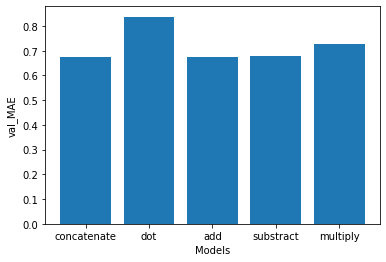

In [94]:
# we can directly acess the mae and val_mae if we safe the model under the name history (command will be 
# history.history['MAE'])
import matplotlib.pyplot as plt
%matplotlib inline
models=('concatenate', 'dot', 'add', 'substract', 'multiply')
mae_values=(MAE_model_concatenate, MAE_model_dot, MAE_model_add, MAE_model_substract, MAE_model_mulitply)
val_mae_values=(val_MAE_model_concatenate, val_MAE_model_dot, val_MAE_model_add, val_MAE_model_substract, val_MAE_model_multiply )
pos=np.arange(len(models))
plt.bar(pos,val_mae_values,align='center')
plt.xticks(pos,models)
plt.ylabel('val_MAE')
plt.xlabel('Models')
plt.show()

In [56]:
# example prediction

In [97]:
# User 
ratings_per_user = data.groupby('user_id').size()
uid = 1
user_ratings = data[data.user_id==uid]
print("User #{} has rated {} movies (avg. rating = {:.1f}):".format(
    uid, len(user_ratings), user_ratings['rating'].mean(),
))
cols = ['user_id', 'movie_id', 'rating']
user_ratings.sort_values(by='rating', ascending=False)[cols]

User #1 has rated 232 movies (avg. rating = 4.4):


,user_id,movie_id,rating
231,1,5060,5.0
185,1,2872,5.0
89,1,1291,5.0
90,1,1298,5.0
190,1,2948,5.0
...,...,...,...
170,1,2617,2.0
143,1,2253,2.0
148,1,2338,2.0
152,1,2389,2.0


In [104]:
# predicting for movies from the test data
movies_from_test=test.movie_id[test.user_id==uid].unique()
# prediction 
pred_concatenate=model_concatenate.predict([[uid]*len(movies_from_test),movies_from_test])
pred_dot=model_dot.predict([[uid]*len(movies_from_test),movies_from_test])
pred_add=model_add.predict([[uid]*len(movies_from_test),movies_from_test])
pred_substract=model_substract.predict([[uid]*len(movies_from_test),movies_from_test])
pred_multiply=model_multiply.predict([[uid]*len(movies_from_test),movies_from_test])

In [105]:
user_data_test=test[test.user_id==uid][cols]
user_data_test['model_concatenate']=pred_concatenate
user_data_test['model_dot']=pred_dot
user_data_test['model_add']=pred_add
user_data_test['model_substract']=pred_substract
user_data_test['model_multiply']=pred_multiply
user_data_test.sort_values(by='rating', ascending=False)

,user_id,movie_id,rating,model_concatenate,model_dot,model_add,model_substract,model_multiply
115,1,1954,5.0,4.195483,3.378325,4.460609,4.572939,4.658683
156,1,2427,5.0,4.429301,3.377683,3.810176,4.075404,3.651727
8,1,151,5.0,4.329728,3.482941,4.424371,4.315084,2.514507
88,1,1282,5.0,3.618984,3.379715,4.327693,4.591249,3.920656
147,1,2329,5.0,5.100076,3.383530,4.949581,4.856368,4.619689
103,1,1617,5.0,4.322828,4.250182,4.608250,4.641860,4.856946
179,1,2700,5.0,3.770428,3.389665,4.625636,4.673508,4.478160
135,1,2116,5.0,4.353948,3.472209,3.699026,3.685476,4.042025
158,1,2459,5.0,3.471970,3.386013,3.684066,3.851200,3.349759
149,1,2353,5.0,4.135435,3.463192,4.051669,4.327375,3.290742


In [106]:
movie_name=lambda movie: data.title[data.movie_id==movie]
top5_model_concatenate_test=user_data_test.nlargest(5,'model_concatenate').movie_id.map(movie_name)
top5_model_dot_test=user_data_test.nlargest(5,'model_dot').movie_id.map(movie_name)
top5_model_add_test=user_data_test.nlargest(5,'model_add').movie_id.map(movie_name)
top5_model_substract_test=user_data_test.nlargest(5,'model_substract').movie_id.map(movie_name)
top5_model_multiply_test=user_data_test.nlargest(5,'model_multiply').movie_id.map(movie_name)

pd.DataFrame({'top5_model_concatenate': top5_model_concatenate_test.values, 'top5_model_dot':top5_model_dot_test.values, 'top5_model_add':  top5_model_add_test.values, 'top5_model_substract': top5_model_substract_test.values, 'top5_model_mulitply': top5_model_multiply.values})

,top5_model_concatenate,top5_model_dot,top5_model_add,top5_model_substract,top5_model_mulitply
0,147 American History X (1998) 1451 Am...,103 L.A. Confidential (1997) 327 L.A...,147 American History X (1998) 1451 Am...,70 Raiders of the Lost Ark (Indiana Jone...,1660 Laputa: Castle in the Sky (Tenkû no s...
1,219 Gladiator (2000) 233 Gladiator (...,219 Gladiator (2000) 233 Gladiator (...,70 Raiders of the Lost Ark (Indiana Jone...,219 Gladiator (2000) 233 Gladiator (...,6843 Roger & Me (1989) 9873 Roger & Me...
2,70 Raiders of the Lost Ark (Indiana Jone...,142 Willow (1988) 2352 Willow (1988) ...,114 All Quiet on the Western Front (1930)...,147 American History X (1998) 1451 Am...,"1175 Notebook, The (2004) 1340 Noteboo..."
3,"202 Longest Day, The (1962) 4097 Long...",106 I Know What You Did Last Summer (1997...,222 Blazing Saddles (1974) 2392 Blazi...,75 Alien (1979) 1445 Alien (1979) 15...,"4173 African Queen, The (1951) 7272 Af..."
4,97 Grosse Pointe Blank (1997) 324 G...,182 Big (1988) 2371 Big (1988) 6555 ...,87 Young Frankenstein (1974) 2319 Yo...,222 Blazing Saddles (1974) 2392 Blazi...,"24315 Man Who Shot Liberty Valance, The (19..."
